In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id_x,home_team_name,away_team_api_id_x,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_team_api_id_y,away_team_api_id_y,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,L,8472,8650,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,L,8654,8528,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,L,8668,8655,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,L,8549,8586,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,L,8559,10194,1600.0,1600.0


## Running Multinomial Logit on Nominal Classes w/ Elo Score

#### Issue with burn-in for elo, ignore and fix later

In [30]:
#np.random.seed(1)
show_distr = False
X = data[data.columns[7:]].drop(
    ['result', 'home_team_api_id_y', 'away_team_api_id_y', 'away_team_goal', 'home_team_goal'],
axis = 1)
y = data['result']


size = np.min(np.unique(y, return_counts = True)[1])
X_s = StandardScaler().fit_transform(X)
W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
D = np.random.choice(np.arange(y.shape[0])[y == 'D'], size = size)
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

new_idx = np.concatenate([W, D, L])
X_i = X_s[new_idx]
y_i = y[new_idx]

# Stratify takes 75% from each class, works if we fix imbalance in original data
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)

if show_distr:
    pd.DataFrame(np.array(np.unique(y_i, return_counts = True)).T, columns = ['Label', 'n']).sort_values(by = 'n')

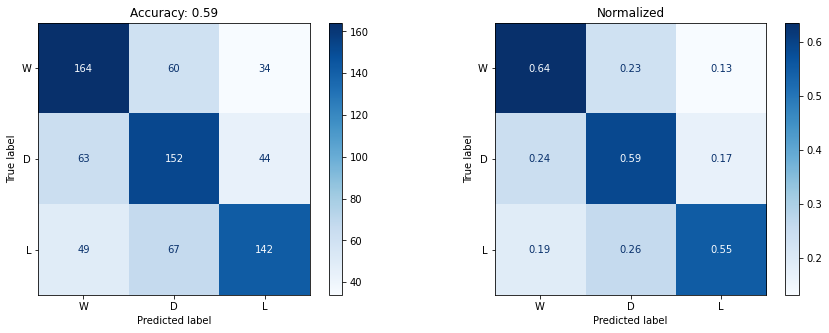

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.635659   0.594203  0.635659  0.614232      258
1      D  0.586873   0.544803  0.586873  0.565056      259
2      L  0.550388   0.645455  0.550388  0.594142      258
3  Total  0.590968   0.594756  0.590968  0.591110      775


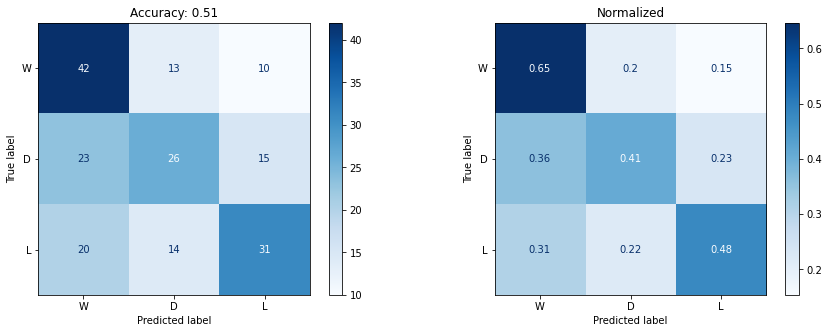

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.646154   0.494118  0.646154  0.560000       65
1      D  0.406250   0.490566  0.406250  0.444444       64
2      L  0.476923   0.553571  0.476923  0.512397       65
3  Total  0.510309   0.512866  0.510309  0.505929      194


In [31]:
params = {
    'multi_class' : 'multinomial'
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train))
print(metric_suite(clf, X_test, y_test))

## Running Multinomial Logit on Nominal Classes w/o Elo Score

In [79]:
X = data[data.columns[7:]].drop(
    ['away_team_goal', 'home_team_goal',
     'result', 'home_team_api_id_y',
     'away_team_api_id_y', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

size = np.min(np.unique(y, return_counts = True)[1])
X_s = StandardScaler().fit_transform(X)
W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
D = np.random.choice(np.arange(y.shape[0])[y == 'D'], size = size)
#D = np.arange(y.shape[0])[y == 'D']
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

new_idx = np.concatenate([W, D, L])
X_i = X_s[new_idx]
y_i = y[new_idx]
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)

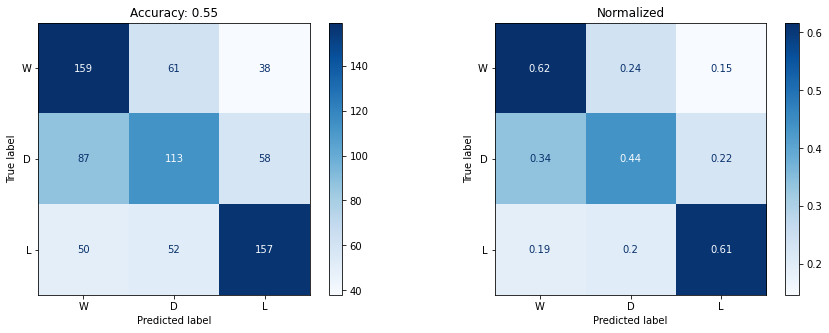

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.616279   0.537162  0.616279  0.574007      258
1      D  0.437984   0.500000  0.437984  0.466942      258
2      L  0.606178   0.620553  0.606178  0.613281      259
3  Total  0.553548   0.552660  0.553548  0.551490      775


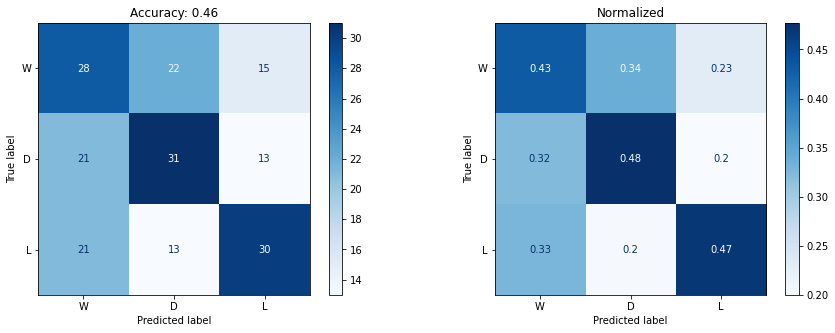

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.430769   0.400000  0.430769  0.414815       65
1      D  0.476923   0.469697  0.476923  0.473282       65
2      L  0.468750   0.517241  0.468750  0.491803       64
3  Total  0.458763   0.462030  0.458763  0.459803      194


In [80]:
params = {
    'multi_class' : 'multinomial'
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train))
print(metric_suite(clf, X_test, y_test))

In [92]:
base_df = pd.DataFrame({'class': (['D']*58) + (['L']*58) + (['W']*58),'feature' : list(X.columns)*3,'log_odds' : np.reshape(clf.coef_, -1)})

In [95]:
base_df['out'] = base_df['log_odds'].apply(lambda x: 0 if x < 0 else 1)

In [117]:
r = []
for i in range(11):
    ts = np.zeros(58)
    ts[np.where(X.columns == 'home_team_card_color_r')[0][0]] = i
    r += [clf.predict_proba(ts.reshape(1, -1))]


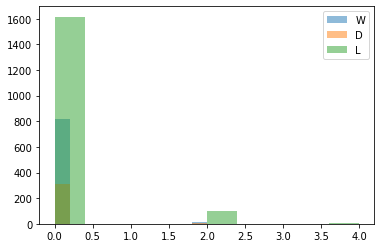

In [146]:
#data[['result', 'home_team_card_color_r']].groupby(by = 'result').mean()
plt.hist(data[data['result'] == 'W']['home_team_card_color_r'], alpha = 0.5)
plt.hist(data[data['result'] == 'D']['home_team_card_color_r'], alpha = 0.5)
plt.hist(data[data['result'] == 'L']['home_team_card_color_r'], alpha = 0.5)
plt.legend(labels = ['W', 'D', 'L'])
plt.show()

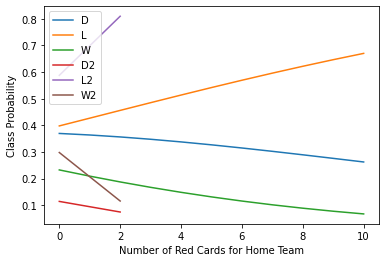

In [159]:
plt.plot(np.array(r).reshape(11, 3))
plt.plot([0,2],[np.unique(data[data['home_team_card_color_r'] == x]['result'], return_counts = True)[1]/np.sum(data['home_team_card_color_r'] == x) for x in [0, 2]]
)
plt.legend(labels = list(clf.classes_) + ['D2', 'L2', 'W2'] )
plt.xlabel('Number of Red Cards for Home Team')
plt.ylabel('Class Probability')
plt.show()

In [157]:
[np.unique(data[data['home_team_card_color_r'] == x]['result'], return_counts = True)[1]/np.sum(data['home_team_card_color_r'] == x) for x in [0, 2]]


[array([0.11422335, 0.58785013, 0.29792652]),
 array([0.07438017, 0.80991736, 0.11570248])]

### Trying again w/o Elo PREM data with Class Weights

In [257]:
X = data[data.columns[9:]].drop(
    ['result', 'home_team_api_id_y',
     'away_team_api_id_y', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

scaler = StandardScaler().fit(X)
X_s = scaler.transform(X)
size = np.min(np.unique(y[y != 'D'], return_counts = True)[1])
W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

idx = [W, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])

X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)

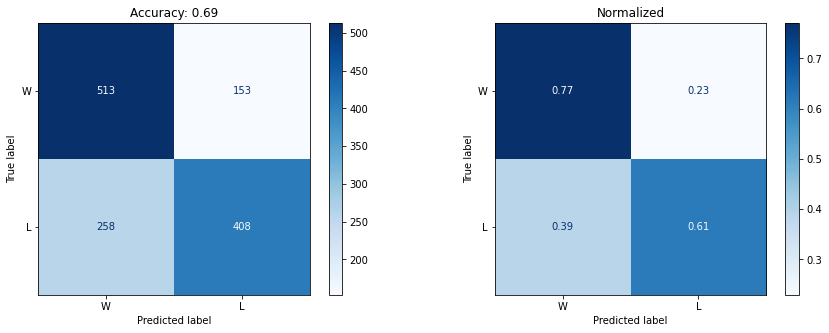

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.770270   0.665370  0.770270  0.713987      666
1      L  0.612613   0.727273  0.612613  0.665037      666
2  Total  0.691441   0.696321  0.691441  0.689512     1332


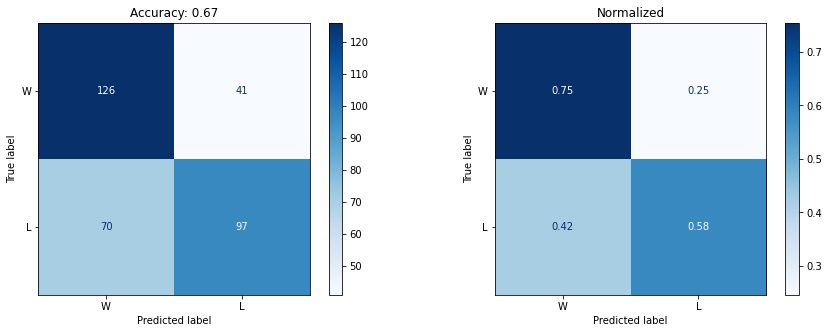

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.754491   0.642857  0.754491  0.694215      167
1      L  0.580838   0.702899  0.580838  0.636066      167
2  Total  0.667665   0.672878  0.667665  0.665140      334


In [262]:
params = {
    'multi_class' : 'multinomial'#,
    #'class_weight': weights
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train, labels = ['W', 'L']))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'L']))

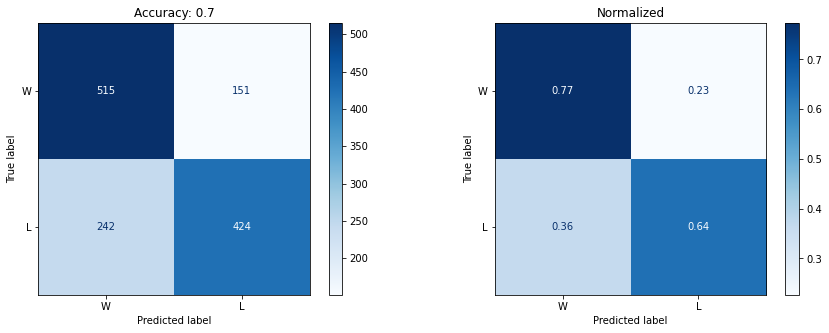

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.773273   0.680317  0.773273  0.723823      666
1      L  0.636637   0.737391  0.636637  0.683320      666
2  Total  0.704955   0.708854  0.704955  0.703571     1332


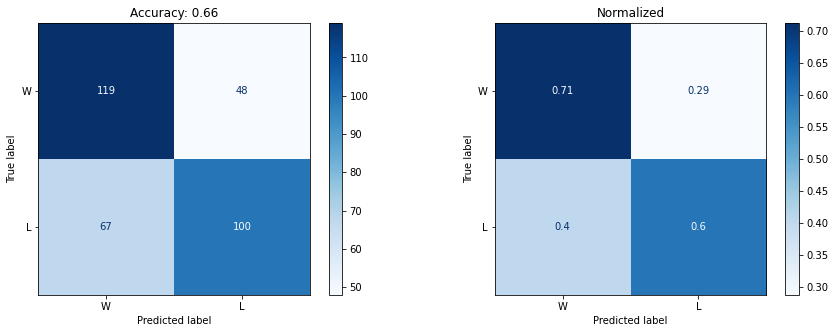

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.712575   0.639785  0.712575  0.674221      167
1      L  0.598802   0.675676  0.598802  0.634921      167
2  Total  0.655689   0.657730  0.655689  0.654571      334


In [212]:
params = {
    'multi_class' : 'multinomial'#,
    #'class_weight': weights
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train, labels = ['W', 'L']))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'L']))

/Users/kayacelebi/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kayacelebi/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kayacelebi/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kayacelebi/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


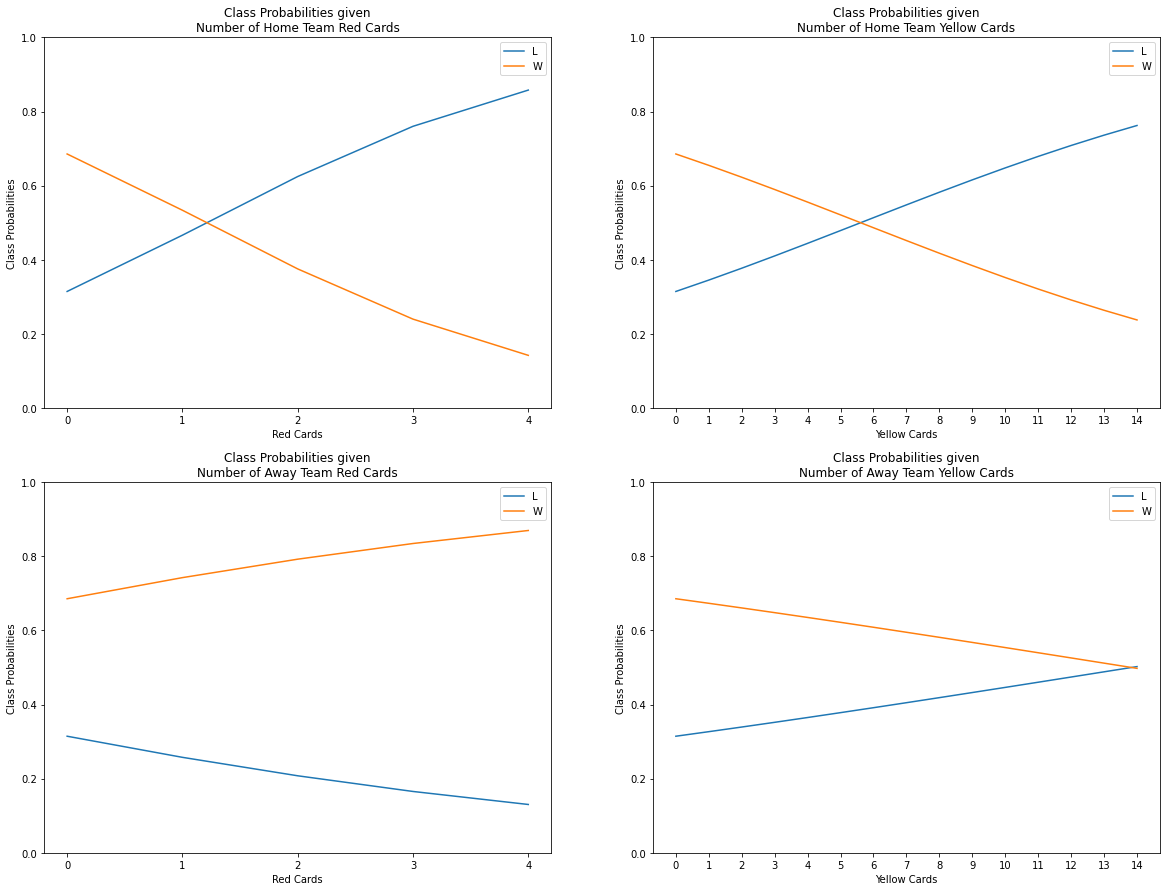

In [265]:
fig, axs = plt.subplots(2,2, figsize = (20,15))
n = 5
ts = np.zeros((n, 58))
ts[:, np.where(X.columns == 'home_team_card_color_r')[0][0]] = np.arange(n)
ts = scaler.transform(ts)
axs[0,0].plot(clf.predict_proba(ts))
axs[0,0].set_xlabel('Red Cards')
axs[0,0].set_ylabel('Class Probabilities')
axs[0,0].set_title('Class Probabilities given\nNumber of Home Team Red Cards')
axs[0,0].set_xticks(range(n))
axs[0,0].set_ylim([0,1])
axs[0,0].legend(labels = clf.classes_)

n = 15
ts = np.zeros((n, 58))
ts[:, np.where(X.columns == 'home_team_card_color_y')[0][0]] = np.arange(n)
ts = scaler.transform(ts)
axs[0,1].plot(clf.predict_proba(ts))
axs[0,1].set_xlabel('Yellow Cards')
axs[0,1].set_ylabel('Class Probabilities')
axs[0,1].set_title('Class Probabilities given\nNumber of Home Team Yellow Cards')
axs[0,1].set_xticks(range(n))
axs[0,1].set_ylim([0,1])
axs[0,1].legend(labels = clf.classes_)

n = 5
ts = np.zeros((n, 58))
ts[:, np.where(X.columns == 'away_team_card_color_r')[0][0]] = np.arange(n)
ts = scaler.transform(ts)
axs[1,0].plot(clf.predict_proba(ts))
axs[1,0].set_xlabel('Red Cards')
axs[1,0].set_ylabel('Class Probabilities')
axs[1,0].set_title('Class Probabilities given\nNumber of Away Team Red Cards')
axs[1,0].set_xticks(range(n))
axs[1,0].set_ylim([0,1])
axs[1,0].legend(labels = clf.classes_)

n = 15
ts = np.zeros((n, 58))
ts[:, np.where(X.columns == 'away_team_card_color_y')[0][0]] = np.arange(n)
ts = scaler.transform(ts)
axs[1,1].plot(clf.predict_proba(ts))
axs[1,1].set_xlabel('Yellow Cards')
axs[1,1].set_ylabel('Class Probabilities')
axs[1,1].set_title('Class Probabilities given\nNumber of Away Team Yellow Cards')
axs[1,1].set_xticks(range(n))
axs[1,1].set_ylim([0,1])
axs[1,1].legend(labels = clf.classes_)
plt.show()

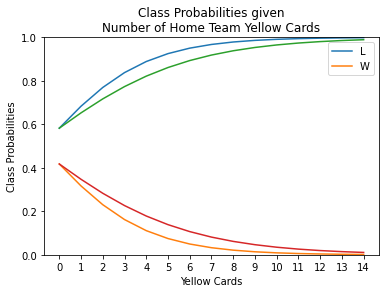

In [256]:
n = 15
ts = np.zeros((n, 58))
ts[:, np.where(X.columns == 'home_team_card_color_y')[0][0]] = np.arange(n)
plt.plot(clf.predict_proba(ts))
ts = np.zeros((n, 58))
ts[:, np.where(X.columns == 'home_team_card_color_y2')[0][0]] = np.arange(n)
plt.plot(clf.predict_proba(ts))
plt.xlabel('Yellow Cards')
plt.ylabel('Class Probabilities')
plt.title('Class Probabilities given\nNumber of Home Team Yellow Cards')
plt.xticks(range(n))
plt.ylim([0,1])
plt.legend(labels = clf.classes_)
plt.show()

In [206]:
X = data[data.columns[9:]].drop(
    ['result', 'home_team_api_id_y',
     'away_team_api_id_y', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

size = np.min(np.unique(y, return_counts = True)[1])
X_s = StandardScaler().fit_transform(X)
W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
D = np.random.choice(np.arange(y.shape[0])[y == 'D'], size = size)
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

idx = [W, D, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'D', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])

X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)

In [208]:
weights

{'W': 2.5789473684210527, 'D': 1.0, 'L': 5.315789473684211}

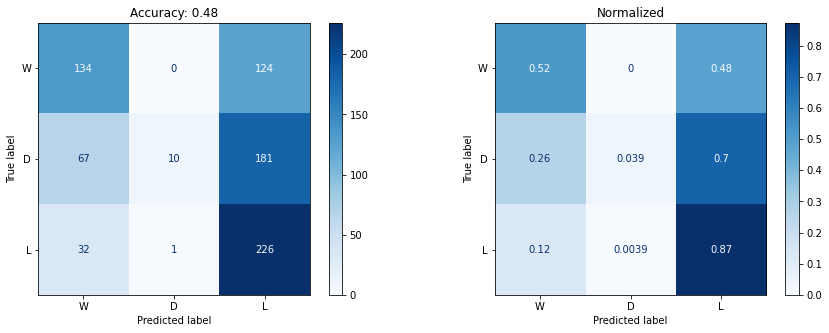

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.519380   0.575107  0.519380  0.545825      258
1      D  0.038760   0.909091  0.038760  0.074349      258
2      L  0.872587   0.425612  0.872587  0.572152      259
3  Total  0.477419   0.636331  0.477419  0.397667      775


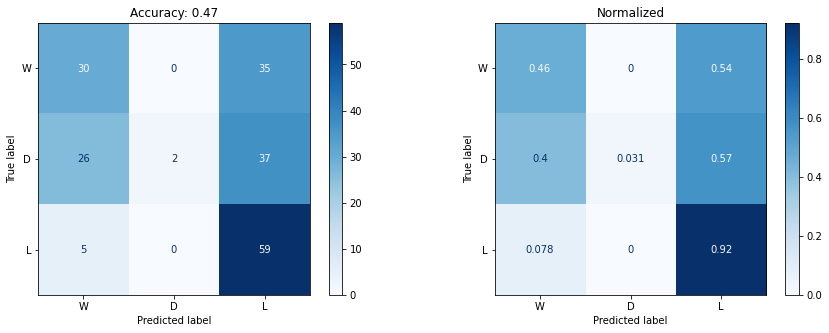

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.461538   0.491803  0.461538  0.476190       65
1      D  0.030769   1.000000  0.030769  0.059701       65
2      L  0.921875   0.450382  0.921875  0.605128       64
3  Total  0.469072   0.648411  0.469072  0.379181      194


In [207]:
params = {
    'multi_class' : 'multinomial',
    'class_weight': weights
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train))
print(metric_suite(clf, X_test, y_test))

### Trying for La Liga Data

In [161]:
laliga_data = pd.read_csv('../data/laliga_data_elo.csv', index_col = 'Unnamed: 0')
laliga_data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,530023,21518,2008-08-30 00:00:00,10267,Valencia CF,8661,RCD Mallorca,3,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,1600.0,1600.0
1,530090,21518,2008-08-30 00:00:00,8558,RCD Espanyol,10281,Real Valladolid,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,1600.0,1600.0
2,530086,21518,2008-08-31 00:00:00,8388,CD Numancia,8634,FC Barcelona,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,1600.0,1600.0
3,530085,21518,2008-08-31 00:00:00,9783,RC Deportivo de La Coruña,8633,Real Madrid CF,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,530095,21518,2008-09-13 00:00:00,8634,FC Barcelona,8696,Racing Santander,1,4,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,L,1590.0,1600.0


In [191]:
X = laliga_data[laliga_data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = laliga_data['result']

X_m = X[y != 'D']
y_m = y[y != 'D']

X_s = StandardScaler().fit_transform(X_m)

X_train, X_test, y_train, y_test = train_test_split(X_s, y_m, test_size = 0.2, stratify = y_m)

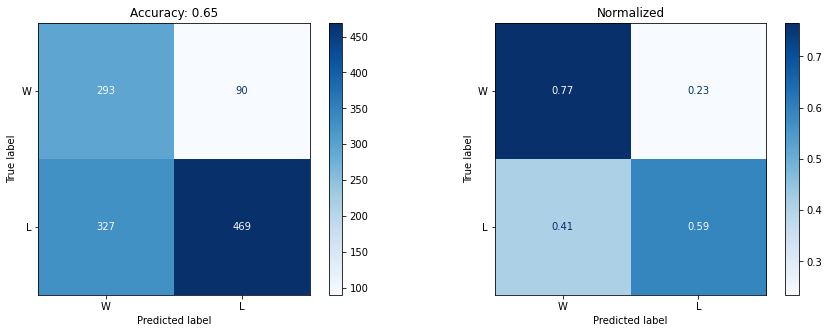

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.765013   0.472581  0.765013  0.584247      383
1      L  0.589196   0.838998  0.589196  0.692251      796
2  Total  0.646310   0.719967  0.646310  0.657166     1179


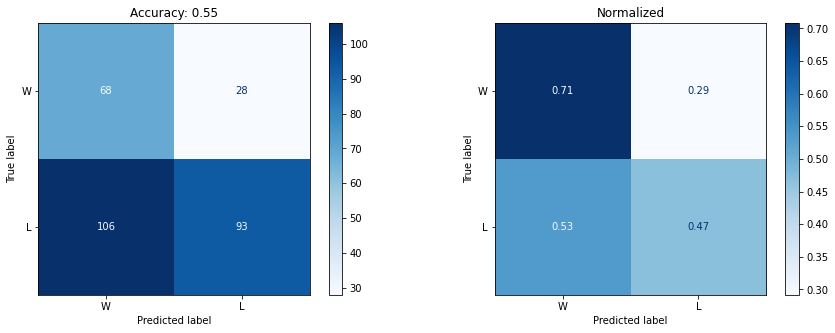

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.708333   0.390805  0.708333  0.503704       96
1      L  0.467337   0.768595  0.467337  0.581250      199
2  Total  0.545763   0.645653  0.545763  0.556015      295


In [192]:
params = {
    'multi_class' : 'multinomial',
    'class_weight' : 'balanced'
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train, labels = ['W', 'L']))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'L']))